In [1]:
import torch
torch.cuda.is_available() # check if GPU is enabled


#conda install conda-forge::pysqlite3 conda-forge::sqlite conda-forge:libsqlite #for fresh install, in case sqlite is reporting error, uninstall and run this in the prompt.

True

In [2]:
# please take note that this notebook is written in WSL2 for the support of tensorflow.
# It is propablity easier to run this notebook in Linux, I guess.
# For MacOS users, please be aware that it does not have offical CUDA support.
# below is all the packages needed
#help('modules') # unmark this if needed (it is quite slow)

In [3]:
# below is the python version infomation
import sys
print(sys.version)

3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [4]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# preprocessing
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
nltk.download("punkt_tab") 
nltk.download('stopwords')
nltk.download('wordnet')
#nltk.download() # you will need this at first run


import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_trf')
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import logging

# conda install -c conda-forge spacy
# conda install -c conda-forge cupy
# python -m spacy download en_core_web_trf # you will need this to install spacy


from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# transformers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch

from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt_tab to /home/see/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/see/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/see/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/see/anaconda3/envs/pt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# import data 
fake_or_real_news = pd.read_csv("/mnt/c/Users/seesu/Desktop/New folder (4)/Individual/fake_or_real_news.csv").drop('Unnamed: 0', axis=1)


# EDA
learned from: https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

#### Check duplicates 

In [6]:
print("Number of duplicates in fake_or_real_news: ", fake_or_real_news.duplicated(["text"]).sum())

# remove duplicates from fake_or_real_news
fake_or_real_news = fake_or_real_news[~fake_or_real_news.duplicated(["text"])].copy(deep=True).reset_index(drop=True)


Number of duplicates in fake_or_real_news:  275


# Pre-Processing


In [7]:
def clean_texts(df_column):
    """
    Clean the text data by removing stopwords, punctuation, tokennize and special characters.
    
    Parameters:
        df_column (str): The text data to clean.
    
    Returns:
        The cleaned text data.
    """

    # expand U.S. 
    df_column = df_column.replace("U.S.", "UnitedStates")
    df_column = df_column.replace("u.s.", "UnitedStates")

    # remove punctuation
    df_column = re.sub(r'[^\w\s]', ' ', df_column)

    # remove special characters
    df_column = re.sub(r'[^\x00-\x7F]+', ' ', df_column)

    # remove extra spaces
    df_column = re.sub(r'\s+', ' ', df_column)

    # contatact numbers toghther 
    df_column = re.sub(r'(\d+)\s+(\d+)', r'\1\2', df_column)

    # remove non-alphabetic characters
    df_column = re.sub(r'[^a-zA-Z]', ' ', df_column)

    # tokenize
    df_column = word_tokenize(df_column)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    df_column = [word for word in df_column if word.lower() not in stop_words]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    df_column = [lemmatizer.lemmatize(word) for word in df_column]
    

    return " ".join(df_column).lower()


In [8]:
# fake_or_real_news data
fake_or_real_news['cleaned_text'] = fake_or_real_news['text'].apply(clean_texts)

In [15]:
# export to csv for tendor model using
fake_or_real_news.to_csv('cleaned_news.csv', index=False)

## Transformer
from: 
https://huggingface.co/hamzab/roberta-fake-news-classification

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("hamzab/roberta-fake-news-classification")

model = AutoModelForSequenceClassification.from_pretrained("hamzab/roberta-fake-news-classification")


def predict_fake(title,text):
    input_str = "<title>" + title + "<content>" +  text + "<end>"
    input_ids = tokenizer.encode_plus(input_str, max_length=512, padding="max_length", truncation=True, return_tensors="pt")
    device =  'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    with torch.no_grad():
        output = model(input_ids["input_ids"].to(device), attention_mask=input_ids["attention_mask"].to(device))
    return dict(zip(["Fake","Real"], [x.item() for x in list(torch.nn.Softmax()(output.logits)[0])] ))
    
def get_label(prob_dict):
    return max(prob_dict, key=prob_dict.get)

In [10]:
# make predictions
fake_or_real_news['prediction'] = fake_or_real_news.apply(
    lambda row: predict_fake(row['title'], row['text']), 
    axis=1
)

fake_or_real_news['prediction'] = fake_or_real_news['prediction'].apply(get_label)

# encode the labels
fake_or_real_news['prediction'] = fake_or_real_news['prediction'].map(lambda x: 0 if x == 'Fake' else 1)
fake_or_real_news['encoded_label'] = fake_or_real_news['label'].map(lambda x: 0 if x == 'FAKE' else 1)

/home/see/anaconda3/envs/pt/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [11]:
# calculate the accuracy
accuracy = accuracy_score(fake_or_real_news['encoded_label'], fake_or_real_news['prediction'])
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7564


# Evaluation

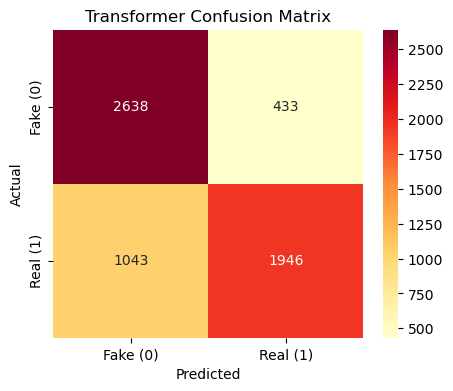

              precision    recall  f1-score   support

           0       0.72      0.86      0.78      3071
           1       0.82      0.65      0.73      2989

    accuracy                           0.76      6060
   macro avg       0.77      0.76      0.75      6060
weighted avg       0.77      0.76      0.75      6060



In [17]:
cm = confusion_matrix(fake_or_real_news['encoded_label'], fake_or_real_news['prediction'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Transformer Confusion Matrix')
plt.show()

report = classification_report(fake_or_real_news['encoded_label'], fake_or_real_news['prediction'])
print(report)